# Table of Contents
* [Loading data](#Loading-data)
* [Object counts](#Object-counts)
* [Image brightness](#Image-brightness)
* [Look at v2 matlab files](#Look-at-v2-matlab-files)
* [Build dataset scaffolding](#Build-dataset-scaffolding)
	* [explore](#explore)
	* [code](#code)
* [hide](#hide)


In [1]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

In [2]:
%%capture
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light solarized
#%base16_mplrc dark solarized
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['figure.figsize'] = (16.0, 10.0)

In [3]:
import glob
import os
import json
import re
import PIL.Image as Image
import PIL.ImageStat as ImageStat
from multiprocessing import Pool
from tqdm import tqdm

# Loading data

In [4]:
all_ds_files = glob.glob('./SUNRGBD/**', recursive=True)
len(all_ds_files)

image_names = [iname for iname in all_ds_files if 'image/' in iname]
img_numbs = sorted([i.split('/')[-1].split('.jpg')[0] for i in image_names])
len(image_names)

d2_anno_names = [iname for iname in all_ds_files if 'annotation2Dfinal/' in iname and not 'json_' in iname]
d3_anno_names = [iname for iname in all_ds_files if 'annotation3Dfinal/' in iname and not 'json_' in iname]
d2_3_anno_names = [iname for iname in all_ds_files if 'annotation2D3D/' in iname and not 'json_' in iname]
anno_types = {
    '2D': d2_anno_names,
    '3D': d3_anno_names,
    '2D3D': d2_3_anno_names
}

In [7]:
# img_pattern = re.compile('.*(img_[0-9]+|NYU[0-9]+|[0-9]+_[0-9]+|[0-9]+-[0-9]+).*')

# sun_rgb_anno = defaultdict(lambda: defaultdict(dict))
# dedupe_count = 0
# for ann_type, anno_names in anno_types.items():
#     for ann_fn in tqdm(anno_names):
#         img_dir = ann_fn.split('/')[-3]
#         try:
#             img_n = re.findall(img_pattern, ann_fn)[0]
#         except IndexError as e:
#             pass
#         with open(ann_fn, 'r') as f:
#             try:
#                 img_annotation = json.load(f)
#             except json.JSONDecodeError as e:
#                 pass
#         sun_rgb_anno[img_dir][ann_type] = img_annotation
#         dedupe_count += 1

In [ ]:
# sun_rgb_anno[comp_k]['2D']['name'] 
# test_img_path = '/'.join(['./SUNRGBD/kv1', sun_rgb_anno[comp_k]['2D']['name'], sun_rgb_anno[comp_k]['2D']['fileList']])
# test_full_anno = sun_rgb_anno[comp_k]

In [ ]:
# list(sun_rgb_anno.values())[47]

In [103]:
test_full_anno.keys()

dict_keys(['2D', '3D', '2D3D'])

In [104]:
t2d = test_full_anno['2D']
t3d = test_full_anno['3D']
t23d = test_full_anno['2D3D']

In [105]:
[ob['name'] for ob in t2d['objects']]

['books',
 'books',
 'books',
 'books',
 'books',
 'cabinet',
 'ceiling',
 'chair',
 'floor',
 'wall',
 'wall',
 'desk',
 'desk',
 'keyboard',
 'monitor',
 'speaker',
 'picture',
 'picture',
 'picture',
 'picture',
 'sofa',
 'books',
 'books',
 'bookshelf',
 'mouse',
 'floor_mat',
 'tv',
 'remote_control']

In [106]:
[ob['name'] for ob in t3d['objects'] if ob]

['desk:occluded',
 'sofa_chair',
 'computer',
 'cabinet',
 'painting',
 'painting',
 'desk',
 'chair',
 'lamp',
 'books']

In [107]:
[ob['name'] for ob in t23d['objects'] if ob]

['desk:occluded',
 'sofa_chair',
 'computer',
 'cabinet',
 'painting',
 'painting',
 'desk',
 'chair',
 'lamp',
 'books',
 'bookshelf',
 'bookshelf']

In [111]:
t2d

{'conflictList': [None],
 'date': '',
 'extrinsics': '20150119000253.txt',
 'fileList': 'NYU0355.jpg',
 'frames': [{'polygon': [{'object': 0,
     'x': [44, 45, 63, 88, 94, 99, 95, 82, 44, 44],
     'y': [190, 185, 190, 181, 190, 226, 228, 237, 237, 190]},
    {'object': 1,
     'x': [14, 98, 103, 105, 101, 15, 14],
     'y': [56, 65, 72, 86, 85, 83, 56]},
    {'object': 2,
     'x': [18, 37, 42, 102, 108, 110, 106, 20, 18],
     'y': [96, 92, 97, 103, 107, 120, 120, 121, 96]},
    {'object': 3,
     'x': [23, 94, 107, 108, 25, 23],
     'y': [131, 127, 131, 149, 153, 131]},
    {'object': 4,
     'x': [25, 101, 107, 110, 102, 45, 41, 26, 25],
     'y': [162, 161, 164, 176, 179, 180, 186, 188, 162]},
    {'object': 5,
     'x': [384,
      410,
      414,
      421,
      430,
      441,
      470,
      483,
      503,
      516,
      529,
      523,
      527,
      494,
      386,
      386,
      391,
      391,
      384],
     'y': [181,
      174,
      181,
      180,
      18

In [109]:
t23d['objects']

[{'name': 'desk:occluded',
  'polygon': [{'X': [-1.003591964, 0.267760097, 0.6449091646, -0.6264428963],
    'Ymax': 0.622825368,
    'Ymin': 1.410605634,
    'Z': [5.724626785, 4.609180304, 5.03904337, 6.154489852],
    'rectangle': 1}]},
 {'name': 'sofa_chair',
  'polygon': [{'X': [-0.9178500398,
     -0.2167051054,
     0.3692503758,
     -0.3318945587],
    'Ymax': 0.6607081394,
    'Ymin': 1.461644238,
    'Z': [1.482628632, 0.8679109673, 1.536249851, 2.150967515],
    'rectangle': 1}]},
 {'name': 'computer',
  'polygon': [{'X': [-0.343652369, 0.08500937518, 0.1762547588, -0.2524069854],
    'Ymax': 0.2012474698,
    'Ymin': 0.627574427,
    'Z': [5.581262637, 5.208032469, 5.312829478, 5.686059646],
    'rectangle': 1}]},
 {'name': 'cabinet',
  'polygon': [{'X': [0.6783374353, 1.353784193, 1.732437102, 1.057420945],
    'Ymax': 0.4392045975,
    'Ymin': 1.414204597,
    'Z': [3.951918602, 3.309709491, 3.706562587, 4.350621645],
    'rectangle': 1}]},
 {'name': 'painting',
  'polyg

In [108]:
[ob.item() for ob in new_image_anno['groundtruth2DBB'][0]['classname'][0].tolist()]

['grandfatherclock',
 'sofa',
 'sofa',
 'sofa',
 'sofa',
 'sofa',
 'ottoman',
 'ottoman',
 'ottoman']

In [87]:
new_image_anno

array([ (array(['SUNRGBD/kv1/NYUdata/NYU0352'], 
      dtype='<U27'), array([[ (array([[0]], dtype=uint8), array([[  74.        ,    1.        ,  107.63075196,  310.02469136]]), array(['grandfatherclock'], 
      dtype='<U16'), array([[1]], dtype=uint8)),
        (array([[1]], dtype=uint8), array([[ 249.68237935,  113.09988777,   57.98765432,   57.50841751]]), array(['sofa'], 
      dtype='<U4'), array([[0]], dtype=uint8)),
        (array([[2]], dtype=uint8), array([[ 307.19079686,  112.14141414,   33.06734007,   49.84062851]]), array(['sofa'], 
      dtype='<U4'), array([[0]], dtype=uint8)),
        (array([[3]], dtype=uint8), array([[ 340.73737374,  114.5375982 ,   33.54657688,   35.94276094]]), array(['sofa'], 
      dtype='<U4'), array([[0]], dtype=uint8)),
        (array([[4]], dtype=uint8), array([[ 375.72166105,  116.45454545,   29.71268238,   31.62962963]]), array(['sofa'], 
      dtype='<U4'), array([[0]], dtype=uint8)),
        (array([[5]], dtype=uint8), array([[ 407.8305275

In [88]:
test_img_dir = '/'.join(['./SUNRGBD/kv1', sun_rgb_anno[comp_k]['2D']['name']])
frameData = readFrame(test_img_dir, True )

imgRGBWithAnnotations = np.array(frameData.imgRGB, copy=True);

for i in range(0, len(frameData.annotation2D)):

    color = [rand.randint(0,255), rand.randint(0,255), rand.randint(0,255)]
        
    cv2.fillPoly(imgRGBWithAnnotations, [frameData.annotation2D[i]], color)

for i in range(0, len(frameData.annotation2D)):	
    data = frameData.annotation2D[i];
    centroid = np.mean(data,axis=0)
    cv2.putText(imgRGBWithAnnotations, frameData.labels2D[i], (int(centroid[0]), int(centroid[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.7, [0,0,0],2)

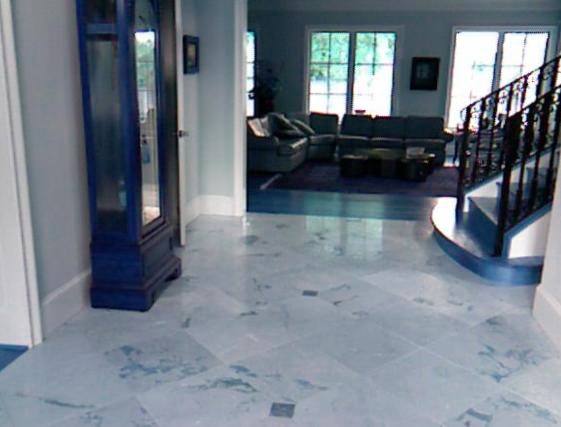

In [89]:
Image.fromarray(frameData.imgRGB)

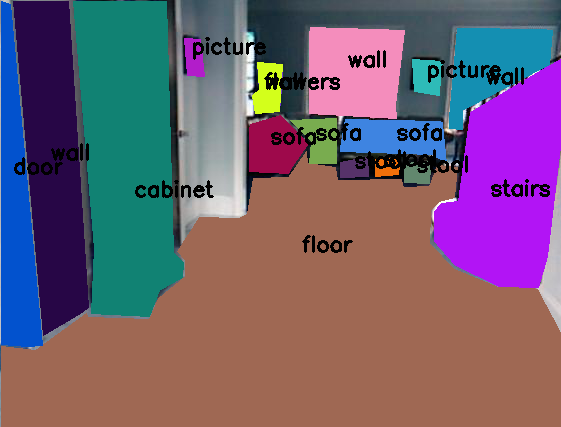

In [90]:
Image.fromarray(imgRGBWithAnnotations)

# Object counts

In [20]:
sun_annos_2d = {img: anno['2D3D'] for img, anno in sun_rgb_anno.items()}

In [21]:
img_objects= {}
for image_anno in sun_annos_2d.values():
    if image_anno:
        objects = [obj['name'] for obj in image_anno['objects'] if obj]
        img_objects[image_anno['name']] = len(objects)

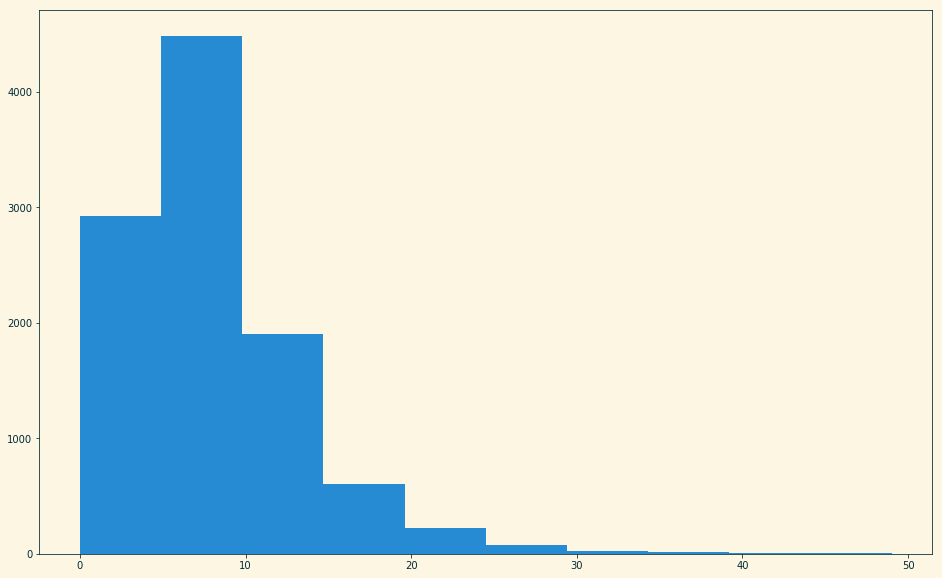

In [22]:
obj_freq_series = pd.Series(list(img_objects.values()))
_ = obj_freq_series[obj_freq_series < 80].hist()

In [23]:
object_counts = Counter()
for image_anno in sun_annos_2d.values():
    if image_anno:
        objects = [obj['name'].lower() for obj in image_anno['objects'] if obj]
        object_counts.update(objects)

In [24]:
freq_series = pd.Series(list(object_counts.values()))

In [25]:
len(freq_series[freq_series > 5])

391

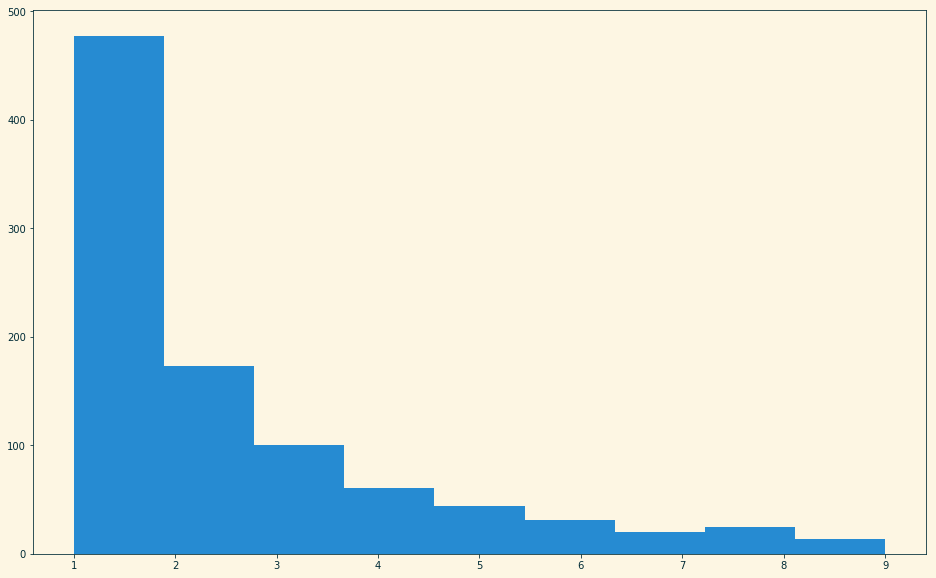

In [26]:
_ = freq_series[freq_series < 10].hist(bins=9)

In [27]:
sum(freq_series)

79569

In [28]:
object_freqs = object_counts.most_common()

In [29]:
len(object_freqs)

1246

In [30]:
object_counts['window']

44

In [31]:
filtered_objs = [ob for ob in object_freqs if ob[1] > 5]
class_freq_series = pd.Series([ob[1] for ob in  filtered_objs])

In [32]:
total_obj_instanc_count = sum(class_freq_series)

In [33]:
total_obj_instanc_count

77982

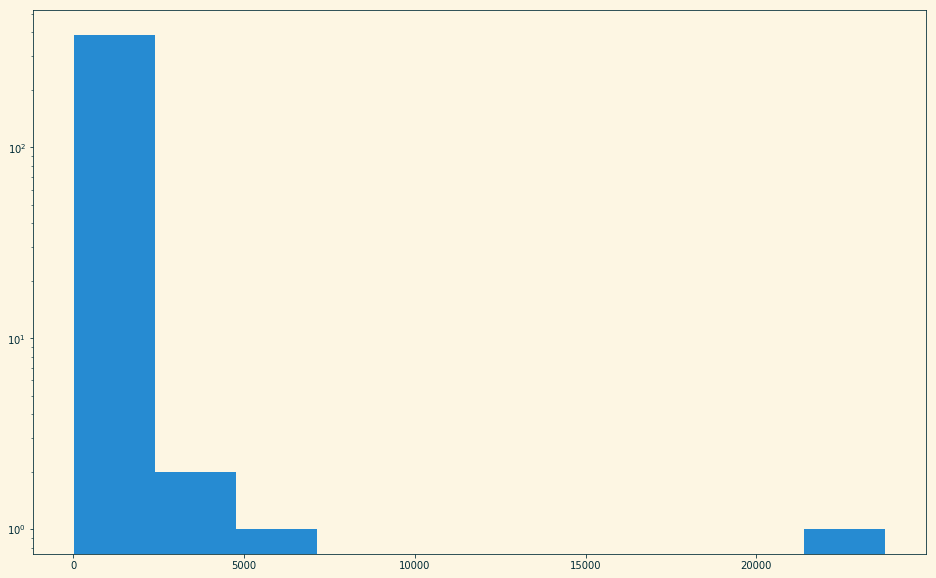

In [34]:
_ = class_freq_series.hist(log=True)

In [35]:
len(filtered_objs)

391

In [36]:
sum([ob[1] for ob in filtered_objs[100:]])

5417

In [37]:
[ob for ob in object_freqs if 'garbage' in ob[0].lower()]

[('garbage_bin', 1269),
 ('garbagebin:occluded', 8),
 ('garbagebin:truncated', 7),
 ('garbage-bin', 6),
 ('garbagebag', 2)]

# Image brightness

In [38]:
def mean_pixel_level(img_file):
    img = Image.open(img_file).convert('L')
    img_stats = ImageStat.Stat(img)
    return img_stats.mean[0]

def compute_img_brightnesses(image_files):
    img_brightnesses = {}
    for img in image_files:
#         img_brightnesses[img.split('/')[-1]] = mean_pixel_level(img)
        img_brightnesses[img] = mean_pixel_level(img)
    return img_brightnesses

In [39]:
%%time
n_processes = 8
pool = Pool(processes=n_processes)

img_split = np.array_split(image_names, n_processes)
pool_results = pool.map(compute_img_brightnesses, img_split)
img_brightnesses = {}
for res in pool_results:
    img_brightnesses.update(res)

CPU times: user 67 ms, sys: 52.3 ms, total: 119 ms
Wall time: 29.1 s


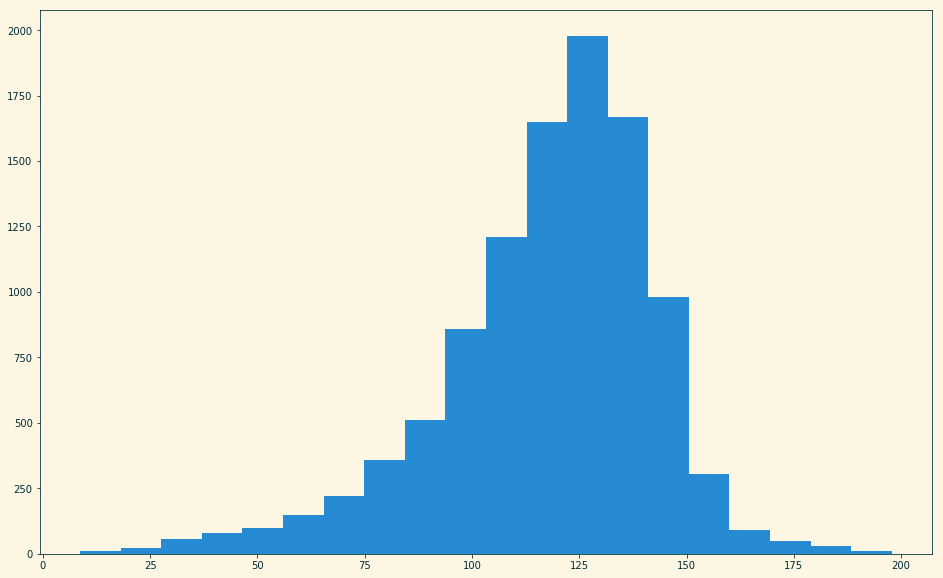

In [40]:
_ = pd.Series(list(img_brightnesses.values())).hist(bins=20)

In [41]:
dim_images = {k: v for k, v in img_brightnesses.items() if v > 50}

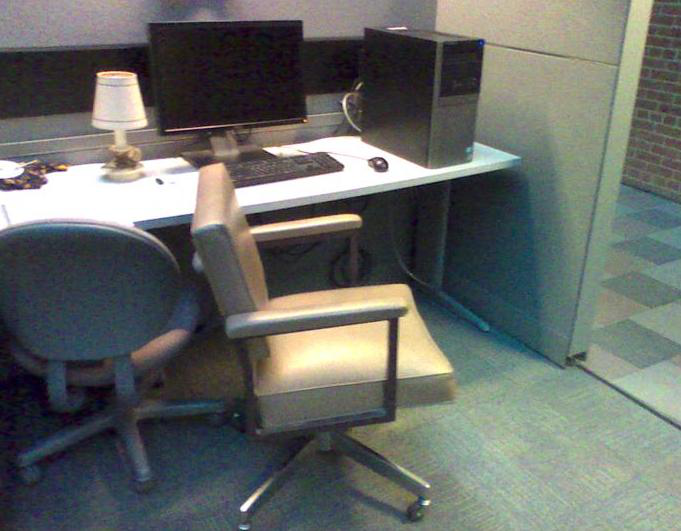

In [42]:
random_img = np.random.choice(list(dim_images.keys()), 1).item()
Image.open(random_img)

In [43]:
rare_objects = [ob[0] for ob in object_freqs if ob[1] < 5]
common_objects = [ob[0] for ob in object_freqs if ob[1] > 5]

In [44]:
object_list = [ob[0] for ob in object_freqs if ob[1] > 5]

In [48]:
len(object_list)

391

In [49]:
deduped_objs = set([ob.lower().split(':')[0] for ob in object_list])
len(deduped_objs)

363

# Look at v2 matlab files

In [5]:
from scipy.io.matlab import loadmat

In [29]:
updated_2d_bbs = loadmat('./SUNRGBDMeta2DBB_v2.mat')['SUNRGBDMeta2DBB']

updated_3d_bbs = loadmat('./SUNRGBDMeta3DBB_v2.mat')['SUNRGBDMeta']

In [130]:
v1_meta = loadmat('SUNRGBDtoolbox/Metadata/SUNRGBDMeta.mat')['SUNRGBDMeta']

In [131]:
v1_meta.dtype.names

('sequenceName',
 'groundtruth3DBB',
 'Rtilt',
 'K',
 'depthpath',
 'rgbpath',
 'anno_extrinsics',
 'depthname',
 'rgbname',
 'sensorType',
 'valid',
 'gtCorner3D',
 'groundtruth2DBB')

In [134]:
v1_meta['sequenceName'][0][0]

array([ 'SUNRGBD/kv2/kinect2data/000002_2014-05-26_14-23-37_260595134347_rgbf000103-resize'], 
      dtype='<U81')

In [140]:
v1_meta['groundtruth3DBB'][0][0]

array([[ (array([[ 0.99221595, -0.12452913,  0.        ],
       [ 0.12452913,  0.99221595,  0.        ],
       [ 0.        ,  0.        ,  1.        ]]), array([[ 0.94379202,  1.15103499,  0.98480693]]), array([[ 1.04730715,  4.16869579, -0.24685933]]), array(['bed'], 
      dtype='<U3'), array([], 
      dtype='<U1'), array([ 'SUNRGBD/kv2/kinect2data/000002_2014-05-26_14-23-37_260595134347_rgbf000103-resize'], 
      dtype='<U81'), array([[-0.12452913, -0.99221595,  0.        ]]), array([[328, 152, 346, 320]], dtype=uint16), array([[1]], dtype=uint8)),
        (array([[ 0.99686539, -0.0791163 ,  0.        ],
       [ 0.08304548,  0.99654576,  0.        ],
       [ 0.        ,  0.        ,  1.        ]]), array([[ 0.2872641,  0.2736726,  0.45     ]]), array([[ 2.43181818,  4.84090909, -0.75      ]]), array(['night_stand'], 
      dtype='<U11'), array([], 
      dtype='<U1'), array([ 'SUNRGBD/kv2/kinect2data/000002_2014-05-26_14-23-37_260595134347_rgbf000103-resize'], 
      dtype='<U

In [141]:
t3dbb['groundtruth3DBB'][0][0]

array([ (array([[ 0.99221595, -0.12452913,  0.        ],
       [ 0.12452913,  0.99221595,  0.        ],
       [ 0.        ,  0.        ,  1.        ]]), array([[ 0.94379202,  1.15103499,  0.98480693]]), array([[ 1.04730715,  4.16869579, -0.24685933]]), array(['bed'], 
      dtype='<U3'), array([ 'SUNRGBD/kv2/kinect2data/000002_2014-05-26_14-23-37_260595134347_rgbf000103-resize'], 
      dtype='<U81'), array([[-0.12452913, -0.99221595,  0.        ]]), array([[1]], dtype=uint8)),
       (array([[ 0.99654576, -0.08304548,  0.        ],
       [ 0.0791163 ,  0.99686539,  0.        ],
       [ 0.        ,  0.        ,  1.        ]]), array([[ 0.44158805,  0.29258647,  0.48666687]]), array([[ 2.58308566,  4.81167455, -0.78666687]]), array(['night_stand'], 
      dtype='<U11'), array([ 'SUNRGBD/kv2/kinect2data/000002_2014-05-26_14-23-37_260595134347_rgbf000103-resize'], 
      dtype='<U81'), array([[-0.0791163 , -0.99686539,  0.        ]]), array([[1]], dtype=uint8)),
       (array([[ 0.994

In [139]:
v1_meta['groundtruth2DBB'][0][0]

array([[(array([[328, 152, 346, 320]], dtype=uint16),),
        (array([[ 568.53840816,  276.61940951,   95.35192217,   92.26649057]]),),
        (array([[324, 319, 325, 211]], dtype=uint16),),
        (array([[154,  17, 151, 368]], dtype=uint16),),
        (array([[  1,   1, 221, 529]], dtype=uint16),)]], 
      dtype=[('gtBb2D', 'O')])

In [57]:
new_image_anno['groundtruth2DBB'][0].dtype.names

('objid', 'gtBb2D', 'classname', 'has3dbox')

In [58]:
comp_k = [k for k in sun_rgb_anno.keys() if 'NYU0352' in k][0]

In [59]:
len(sun_rgb_anno[comp_k]['2D']['frames'][0]['polygon'])

17

In [80]:
t3dbb = updated_3d_bbs[0]

In [108]:
t3dbb['sequenceName']

array([ array([ 'SUNRGBD/kv2/kinect2data/000002_2014-05-26_14-23-37_260595134347_rgbf000103-resize'], 
      dtype='<U81')], dtype=object)

In [109]:
t3dbb.dtype.names

('sequenceName',
 'Rtilt',
 'K',
 'depthpath',
 'rgbpath',
 'anno_extrinsics',
 'depthname',
 'rgbname',
 'sensorType',
 'valid',
 'gtCorner3D',
 'groundtruth3DBB_tight',
 'groundtruth2DBB_tight',
 'groundtruth2DBB_full',
 'groundtruth2DBB_tight_proj',
 'groundtruth3DBB')

In [86]:
for field in t3dbb.dtype.names:
    print(field)
    print(t3dbb[field])
    print()

sequenceName
[ array([ 'SUNRGBD/kv2/kinect2data/000002_2014-05-26_14-23-37_260595134347_rgbf000103-resize'], 
      dtype='<U81')]

Rtilt
[ array([[ 0.979589,  0.012593, -0.200614],
       [ 0.012593,  0.992231,  0.123772],
       [ 0.200614, -0.123772,  0.97182 ]])]

K
[ array([[ 529.5,    0. ,  365. ],
       [   0. ,  529.5,  265. ],
       [   0. ,    0. ,    1. ]])]

depthpath
[ array([ '/n/fs/sun3d/data/SUNRGBD/kv2/kinect2data/000002_2014-05-26_14-23-37_260595134347_rgbf000103-resize/depth/0000103.png'], 
      dtype='<U116')]

rgbpath
[ array([ '/n/fs/sun3d/data/SUNRGBD/kv2/kinect2data/000002_2014-05-26_14-23-37_260595134347_rgbf000103-resize/image/0000103.jpg'], 
      dtype='<U116')]

anno_extrinsics
[ array([[ 0.979589,  0.200614,  0.012593],
       [-0.200614,  0.97182 ,  0.123772],
       [ 0.012593, -0.123772,  0.992231]])]

depthname
[array(['0000103.png'], 
      dtype='<U11')]

rgbname
[array(['0000103.jpg'], 
      dtype='<U11')]

sensorType
[array(['kv2'], 
      dtyp

In [110]:
t3dbb['groundtruth3DBB_tight'][0].dtype.names

('basis',
 'coeffs',
 'centroid',
 'classname',
 'labelname',
 'sequenceName',
 'orientation',
 'gtBb2D',
 'label')

In [112]:
for field in t3dbb['groundtruth3DBB_tight'][0].dtype.names:
    print(field)
    print(t3dbb['groundtruth3DBB_tight'][0][field])
    print()

basis
[[ array([[ 0.99221595, -0.12452913,  0.        ],
       [ 0.12452913,  0.99221595,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])
  array([[ 0.99686539, -0.0791163 ,  0.        ],
       [ 0.08304548,  0.99654576,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])
  array([[ 0.99409097, -0.10855016,  0.        ],
       [ 0.10333986,  0.99464611,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])
  array([[ 0.11196753,  0.99371187,  0.        ],
       [-0.99442258,  0.10546906,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])
  array([[ 0.10468478,  0.99450545,  0.        ],
       [-0.99478144,  0.10202887,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])]]

coeffs
[[array([[ 0.92400014,  1.14883757,  0.94470394]], dtype=float32)
  array([[ 0.26959223,  0.2316215 ,  0.09308134]], dtype=float32)
  array([[ 0.68804926,  0.3227675 ,  0.29647976]], dtype=float32)
  array([[ 0.96939981,  0.29572639,  1.011639  ]],

# Build dataset scaffolding

## explore

In [78]:
import PIL.Image as Image
import cv2
from SUNRGBDtoolbox_python.SUNRGBD import readFrame
import random as rand

In [65]:
random_img = np.random.choice(list(dim_images.keys()), 1).item()

rand_img_dir = random_img.split('image/')[0]
print(rand_img_dir)
frameData = readFrame(rand_img_dir, True )

imgRGBWithAnnotations = np.array(frameData.imgRGB, copy=True);

for i in range(0, len(frameData.annotation2D)):

    color = [rand.randint(0,255), rand.randint(0,255), rand.randint(0,255)]
        
    cv2.fillPoly(imgRGBWithAnnotations, [frameData.annotation2D[i]], color)

for i in range(0, len(frameData.annotation2D)):	
    data = frameData.annotation2D[i];
    centroid = np.mean(data,axis=0)
    cv2.putText(imgRGBWithAnnotations, frameData.labels2D[i], (int(centroid[0]), int(centroid[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.7, [0,0,0],2)

./SUNRGBD/kv2/kinect2data/000808_2014-06-08_17-18-58_260595134347_rgbf000046-resize/


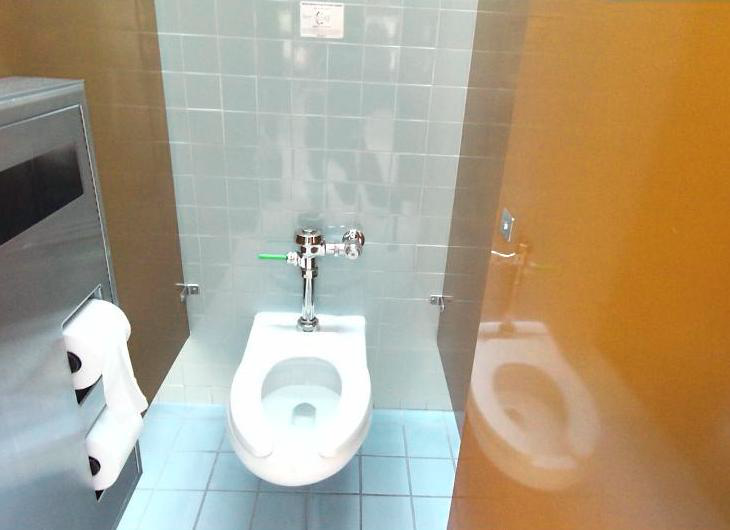

In [67]:
Image.fromarray(frameData.imgRGB)

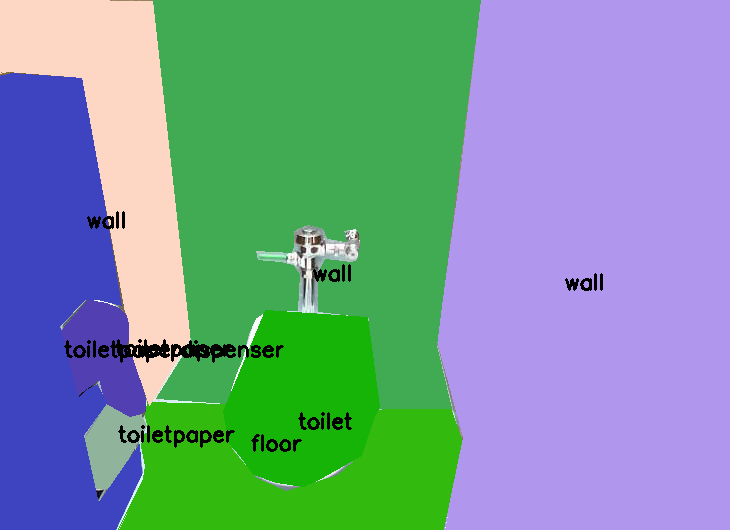

In [68]:
Image.fromarray(imgRGBWithAnnotations)

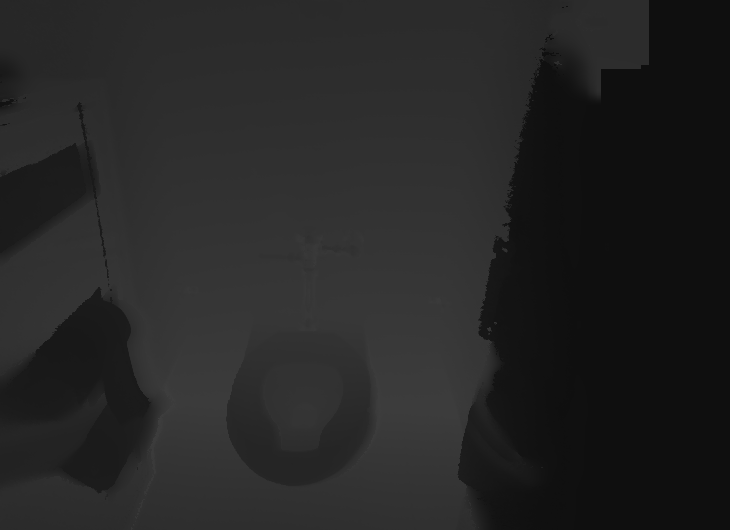

In [69]:
Image.fromarray(frameData.imgD)

plan for assembling this:

Could be a dict of image: to properties, including objects

or just objectIDs to objects, with image as property

each object needs:

id

2D poly, bbox

3D poly, depth, bounding cube

properties



In [70]:
print(sorted([ob2.item() for ob2 in [ob['classname'][0] for ob in  updated_2d_bbs['SUNRGBDMeta2DBB'].T[updated_2d_bbs['SUNRGBDMeta2DBB'].T['sequenceName'] == rand_img_dir[2:-1]]['groundtruth2DBB']][0].tolist()]))

['toilet']


In [71]:
print(sorted([ob2.item() for ob2 in [ob['objid'][0] for ob in  updated_2d_bbs['SUNRGBDMeta2DBB'].T[updated_2d_bbs['SUNRGBDMeta2DBB'].T['sequenceName'] == rand_img_dir[2:-1]]['groundtruth2DBB']][0].tolist()]))

[0]


In [72]:
rand_img_dir

'./SUNRGBD/kv2/kinect2data/000808_2014-06-08_17-18-58_260595134347_rgbf000046-resize/'

In [73]:
print(sorted(frameData.labels2D))

['floor', 'toilet', 'toiletpaper', 'toiletpaper', 'toiletpaperdispenser', 'wall', 'wall', 'wall']


In [74]:
_ = [print(an.shape) for an in frameData.annotation2D]

(19, 2)
(17, 2)
(9, 2)
(20, 2)
(13, 2)
(7, 2)
(44, 2)
(12, 2)


## code

In [34]:
all_ds_files = glob.glob('./SUNRGBD/**', recursive=True)
len(all_ds_files)

image_names = [iname for iname in all_ds_files if 'image/' in iname]
img_numbs = sorted([i.split('/')[-1].split('.jpg')[0] for i in image_names])
len(image_names)

d2_anno_names = [iname for iname in all_ds_files if 'annotation2Dfinal/' in iname and not 'json_' in iname]
d3_anno_names = [iname for iname in all_ds_files if 'annotation3Dfinal/' in iname and not 'json_' in iname]
d2_3_anno_names = [iname for iname in all_ds_files if 'annotation2D3D/' in iname and not 'json_' in iname]

anno_types = {
    '2D': d2_anno_names,
    '3D': d3_anno_names,
    '2D3D': d2_3_anno_names
}

In [35]:
def bbox_from_poly(polygon):
    bbox = None
    return bbox

In [88]:
def build_v2_addition(v2_matlab_arr):
    v2_anno = {}
    for i in range(v2_matlab_arr.shape[0]):
        try:
            image_name = v2_matlab_arr['sequenceName'][i].item()[0].split('/')[-1]
            bboxes = v2_matlab_arr['groundtruth2DBB'][i][0][0]
            v2_anno[image_name] = {
                'objects': {
                    bboxes[j]['objid'].item(): 
                    {
                        'classname': bboxes[j]['classname'].item(),
                        'has3D': bboxes[j]['has3dbox'].item(), 
                        'rect': bboxes[j]['gtBb2D']
                    } 
                    for j in range(bboxes.shape[0])
                }
            }
        except IndexError as e:
             v2_anno[image_name] = {}
    return v2_anno

def build_v2_addition_3d(v2_matlab_arr):
    v2_anno = {}
    for i in range(v2_matlab_arr.shape[0]):
        try:
            image_name = v2_matlab_arr['sequenceName'][i].item()[0].split('/')[-1]
            bboxes = v2_matlab_arr['groundtruth3DBB'][i][0][0]
            print(bboxes.dtype.names)
            print(bboxes)
            v2_anno[image_name] = {
                'objects': {
                    bboxes[j]['objid'].item(): 
                    {
                        'classname': bboxes[j]['classname'].item(),
                        '3D_coords': bboxes[j]['gtCorner3D']
                    } 
                    for j in range(bboxes.shape[0])
                }
            }
        except IndexError as e:
             v2_anno[image_name] = {}
    return v2_anno

In [89]:
def build_dataset(anno_types, v2_add):
    img_pattern = re.compile('.*(img_[0-9]+|NYU[0-9]+|[0-9]+_[0-9]+|[0-9]+-[0-9]+).*')
    sun_rgb_anno = defaultdict(lambda: defaultdict(dict))
    for ann_type, anno_names in anno_types.items():
        for ann_fn in tqdm(anno_names):
            img_dir = ann_fn.split('/')[-3]
            img_n = re.findall(img_pattern, ann_fn)[0]
            with open(ann_fn, 'r') as f:
                try:
                    img_annotation = json.load(f)
                except json.JSONDecodeError as e:
                    pass
            sun_rgb_anno[img_dir][ann_type] = img_annotation
            sun_rgb_anno[img_dir]['v2'] = v2_add[img_dir]
    return {k: dict(v) for k, v in sun_rgb_anno.items()}

## run

In [90]:
# updated_2d_bbs = loadmat('./SUNRGBDMeta2DBB_v2.mat')['SUNRGBDMeta2DBB'].T
# updated_3d_bbs = loadmat('./SUNRGBDMeta3DBB_v2.mat')['SUNRGBDMeta'].T

In [146]:
v2_suppl_2d = build_v2_addition(updated_2d_bbs)

('sequenceName', 'Rtilt', 'K', 'depthpath', 'rgbpath', 'anno_extrinsics', 'depthname', 'rgbname', 'sensorType', 'valid', 'gtCorner3D', 'groundtruth3DBB_tight', 'groundtruth2DBB_tight', 'groundtruth2DBB_full', 'groundtruth2DBB_tight_proj', 'groundtruth3DBB')

In [143]:
# v2_suppl_3d = build_v2_addition_3d(updated_3d_bbs)

In [148]:
sun_ds_scaf = build_dataset(anno_types, v2_suppl_2d)

100%|██████████| 10331/10331 [00:03<00:00, 2975.57it/s]


In [149]:
len(sun_ds_scaf)

10270

In [150]:
test_anno = list(sun_ds_scaf.values())[0]

In [151]:
test_anno.keys()

dict_keys(['2D', 'v2', '3D', '2D3D'])

In [152]:
for test_anno in list(sun_ds_scaf.values())[:100]:
    for at, anno in test_anno.items():
        print(at, len(anno['objects']))
    print()

2D 6
v2 7
3D 10
2D3D 7

2D 21
v2 6
3D 7
2D3D 6

2D 11
v2 4
3D 10
2D3D 4

2D 25
v2 5
3D 8
2D3D 5

2D 23
v2 10
3D 9
2D3D 10

2D 39
v2 4
3D 14
2D3D 4

2D 26
v2 14
3D 15
2D3D 14

2D 23
v2 6
3D 14
2D3D 6

2D 13
v2 7
3D 9
2D3D 7

2D 14
v2 6
3D 9
2D3D 6

2D 27
v2 8
3D 14
2D3D 8

2D 33
v2 5
3D 7
2D3D 5

2D 8
v2 6
3D 12
2D3D 6

2D 13
v2 7
3D 9
2D3D 7

2D 11
v2 2
3D 3
2D3D 2

2D 23
v2 7
3D 10
2D3D 7

2D 16
v2 5
3D 5
2D3D 5

2D 23
v2 7
3D 13
2D3D 7

2D 17
v2 8
3D 12
2D3D 8

2D 19
v2 8
3D 8
2D3D 8

2D 22
v2 8
3D 8
2D3D 8

2D 21
v2 6
3D 11
2D3D 6

2D 13
v2 6
3D 8
2D3D 6

2D 29
v2 7
3D 8
2D3D 7

2D 12
v2 3
3D 5
2D3D 3

2D 19
v2 6
3D 8
2D3D 6

2D 20
v2 6
3D 7
2D3D 6

2D 21
v2 6
3D 8
2D3D 6

2D 23
v2 14
3D 17
2D3D 14

2D 42
v2 3
3D 9
2D3D 3

2D 11
v2 6
3D 7
2D3D 6

2D 8
v2 4
3D 9
2D3D 4

2D 12
v2 6
3D 12
2D3D 6

2D 9
v2 4
3D 17
2D3D 4

2D 19
v2 6
3D 7
2D3D 6

2D 30
v2 9
3D 21
2D3D 9

2D 17
v2 10
3D 16
2D3D 10

2D 23
v2 10
3D 14
2D3D 10

2D 8
v2 4
3D 7
2D3D 4

2D 11
v2 9
3D 11
2D3D 9

2D 27
v2 5
3D 6
2

KeyError: 'objects'

# hide 

In [ ]:
# sum(obj_freq_series.apply(lambda x: x * (x-1)/2)) / 10**6

In [332]:
# updated_2d_bbs['SUNRGBDMeta2DBB'].T[updated_2d_bbs['SUNRGBDMeta2DBB'].T['sequenceName'] == rand_img_dir[2:-1]]

In [ ]:
test_anno = list(sun_rgb_anno.values())[50]